In [1]:
import os
import numpy as np
from sklearn.cluster import KMeans
from feature import feature


class BoW:
    def __init__(self, PathofData, dim=50, method="sift", data_dim=128) -> None:
        self.dim = dim
        self.method = method
        self.data_dim = data_dim
        data = np.empty([0, data_dim])
        for i in PathofData:
            if method in ["sift", "surf", "orb"]:
                feat = feature(i, method, show=False)[1]
            elif method == "shi-tomasi":
                feat = np.squeeze(feature(i, method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                data = np.concatenate((data, feat), axis=0)
        kmeans = KMeans(n_clusters=dim, random_state=0, n_init="auto").fit(data)
        self.kmeans = kmeans

    def fit(self, PathofData):
        N = len(PathofData)
        Word = np.zeros([N, self.dim])
        for index, i in enumerate(PathofData):
            if self.method in ["sift", "surf", "orb"]:
                feat = feature(i, self.method, show=False)[1]
            elif self.method == "shi-tomasi":
                feat = np.squeeze(feature(i, self.method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                label = self.kmeans.predict(feat.astype(float))
                hist, _ = np.histogram(label, bins=range(self.dim + 1))
            else:
                hist=np.zeros((1,self.dim))
            if np.sum(hist)!=0:
                hist=hist/np.sum(hist)
            Word[index] = hist
        return Word
    
    def getSPM(self, PathofData,level):
        width = 500
        N = len(PathofData)
        Word = np.zeros([N, int(self.dim*(4**level-1)/3)])
        for index, i in enumerate(PathofData):
            counter=0
            for l in range(level):
                x,y=0,0
                step=np.floor(width/2**l).astype(int)
                for _ in range(2**l):
                    x=0
                    for _ in range(2**l):
                        if self.method in ["sift", "surf", "orb"]:
                            feat = feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)[1]
                        elif self.method == "shi-tomasi":
                            feat=feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)
                            if feat is not None:
                                feat = np.squeeze(feat,axis=1)
                        else:
                            print("no method. ")
                            return []
                        if feat is not None:
                            label = self.kmeans.predict(feat.astype(float))
                            hist, _ = np.histogram(label, bins=range(self.dim + 1))
                            weight = 2**(l-level)
                            hist=hist*weight
                        else:
                            hist=np.zeros((1,self.dim))
                        Word[index][counter*self.dim:(counter+1)*self.dim]=np.copy(hist)
                        counter+=1
                        x = x + step
                    y=y+step
        return Word

In [2]:
a = np.zeros((209, 0))
b = np.zeros((696, 0))
d = np.zeros((10, 0))
pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"
dim = 20
level=2
Features = [("sift", 128), ("surf", 64), ("orb", 32), ("shi-tomasi", 2)]
# Features = [("shi-tomasi", 2)]
for method, data_dim in Features:
    BoWfu = BoW(
        [pathfu + i for i in os.listdir(pathfu)]+
        [pathnotfu + i for i in os.listdir(pathnotfu)]+
        [pathtest + i for i in os.listdir(pathtest)],
        method=method,
        data_dim=data_dim,
        dim=dim,
    )
    a = np.concatenate(
        (
            a,
            BoWfu.fit([pathfu + i for i in os.listdir(pathfu)]),
        ),
        axis=1,
    )
    b = np.concatenate(
        (
            b,
            BoWfu.fit([pathnotfu + i for i in os.listdir(pathnotfu)]),
        ),
        axis=1,
    )
    d = np.concatenate(
        (
            d,
            BoWfu.fit([pathtest + i for i in os.listdir(pathtest)]),
        ),
        axis=1,
    )
a.shape, b.shape, d.shape

((209, 80), (696, 80), (10, 80))

In [58]:
X = np.concatenate((a, b,d ), axis=0)
y = np.concatenate(( np.ones(209), 0*np.ones(696)))

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50, svd_solver='arpack')
X=pca.fit_transform(X)

In [60]:
X = X[:209+696,:]

In [61]:
new_d=X[-10:,:]

In [79]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

In [51]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5,max_iter=10000))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))])

In [42]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    a = np.sum(minima)
    return a


def kernal(X1, X2):
    result = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            result[i][j] = intersection(X1[i, :], X2[j, :])
    return result


clf = make_pipeline(SVC(gamma="auto", kernel=kernal))
clf.fit(X_train, y_train)

Pipeline(steps=[('svc',
                 SVC(gamma='auto',
                     kernel=<function kernal at 0x7f763df551b0>))])

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    StandardScaler(), AdaBoostClassifier(n_estimators=50, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [60]:
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline( KNeighborsClassifier())
clf.fit(X_train, y_train)#0.79

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])

In [63]:
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(StandardScaler(), RandomForestClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

clf = make_pipeline(StandardScaler(), GradientBoostingClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [28]:
from sklearn.naive_bayes import GaussianNB

clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [69]:
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(MultinomialNB(alpha=0.01))
clf.fit(X_train, y_train)

Pipeline(steps=[('multinomialnb', MultinomialNB(alpha=0.01))])

In [77]:
from xgboost.sklearn import XGBClassifier
## 定义 XGBoost模型 
clf = XGBClassifier()
xgb1 = XGBClassifier(max_depth=6,
                     learning_rate=0.1,
                     n_estimators=5000,
                     silent=False,
                     objective='binary:logistic',
                     booster='gbtree',
                     n_jobs=4,
                     gamma=0,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     reg_alpha=0,
                     seed=888)

# 在训练集上训练XGBoost模型
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
from sklearn.metrics import f1_score
from hyperopt import hp
import xgboost as xgb

def train(args):
    learning_rate=args["learning_rate"]
    n_estimators=args["n_estimators"]
    eta=args["eta"]
    max_depth=args["max_depth"]
    subsample=args["subsample"]
    colsample_bytree=args["colsample_bytree"]
    min_child_weight=args["min_child_weight"]
    reg_alpha=args["reg_alpha"]
    reg_lambda=args["reg_lambda"]

    model = xgb.XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators,eta=eta,
                              max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                              min_child_weight=min_child_weight,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
    model.fit(X_train, y_train)
    return model

def objective(args):
    model=train(args)
    y_pred=model.predict(X_test)
    f1=f1_score(y_test,y_pred,average="macro")
    return -f1

space={"learning_rate":hp.choice("learning_rate", [0.1]),
    "n_estimators":hp.choice("n_estimators",[50, 100, 150, 200, 300]), # 多少棵树
    "eta": hp.choice("eta",[0.05, 0.1, 0, 2, 0.3]),  # 学习率
    "max_depth": hp.choice("max_depth",range(2, 15, 1)),  # 树的最大深度
    "subsample": hp.uniform("subsample", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.98),  # 选择多少列构建一个树
    "min_child_weight": hp.choice("min_child_weight",range(1, 9, 1)),  # 叶子节点最小样本数目
    "reg_alpha": hp.choice("reg_alpha",[0, 0.01, 0.02, 0.05, 0.7, 0.1, 1]),
    "reg_lambda": hp.choice("reg_lambda",[0, 0.1, 0.5, 1])}

from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print(best)
print(space_eval(space, best))

 85%|████████▌ | 425/500 [01:29<00:15,  4.76trial/s, best loss: -0.826005565393372] 


KeyboardInterrupt: 

In [26]:
clf=train(space_eval(space, best))

In [81]:
y_test[y_test==1.0]=-1
y_test[y_test==2.0]=1

In [64]:
y[y==0]=-1

In [81]:
from sklearn.svm import OneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(OneClassSVM(nu=0.5,verbose=True,kernel=kernal))
clf .fit(X[:209,:])

from sklearn.metrics import f1_score

y_pred = clf.predict(X)

print(f1_score(y, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

[LibSVM]*
optimization finished, #iter = 75
obj = -157111.672775, rho = -2519.619154
nSV = 108, nBSV = 103
0.619588062211013


array([[539, 157],
       [107, 102]])

In [98]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=1,novelty=True)
clf .fit(X[:209,:])

from sklearn.metrics import f1_score

y_pred = clf.predict(X)

print(f1_score(y, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

0.5219263894966104


array([[265, 431],
       [  0, 209]])

In [99]:
real = clf.predict(new_d)
print(real)
print(f1_score(np.concatenate((np.ones(5), -np.ones(5))),real, average="macro"))
print(confusion_matrix(real, np.concatenate((np.ones(5), -np.ones(5)))))

[ 1  1 -1  1  1 -1  1 -1  1  1]
0.5833333333333333
[[2 1]
 [3 4]]


In [27]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

0.9333824070666176


array([[139,   4],
       [  4,  34]])

In [28]:
real = clf.predict(d)
print(real)
print(f1_score(np.concatenate(( np.ones(5),0* np.ones(5))),real, average="macro"))
print(confusion_matrix(real, np.concatenate(( np.ones(5), 0*np.ones(5)))))

[0 0 0 0 0 0 0 0 1 1]
0.23076923076923075
[[3 5]
 [2 0]]


In [21]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

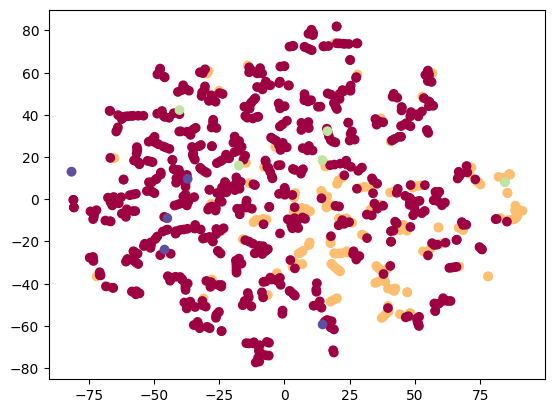

In [22]:
import matplotlib.pyplot as plt
X_embedded
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=np.concatenate((y,2*np.ones(5),3* np.ones(5))), cmap=plt.cm.Spectral)